In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [2]:
raw_df = pd.read_csv('house_price.csv')

/usr/local/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (47,70,71,72,79) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [2]:
house_df = pd.read_csv('data/updated_house_df.csv')
house_df = house_df.drop_duplicates(["deed_date","total_sale_price","heated_area"])
house_df["deed_date"] = pd.to_datetime(house_df["deed_date"])
house_df["year"] = house_df["deed_date"].dt.year

In [3]:
house_df.shape

(284027, 25)

In [4]:
house_df.tail(3).T

,2744422,2744423,2744427
land_sale_price,0.0,0.0,0.0
total_sale_price,602350.0,443100.0,280000.0
deed_date,2019-11-01 00:00:00,2019-11-01 00:00:00,2020-02-01 00:00:00
assessed_building_value,559351.0,411437.0,224222.0
story_height,3.0,3.0,2.0
heated_area,2307,1840,2446
utilities,ALL,ALL,ALL
bath,3.0,3.0,2.5
type_and_use,1.0,1.0,1.0
physical_zip_code,27606,27606,27587


## summary stats and distribution

### land_sale_price

<AxesSubplot:>

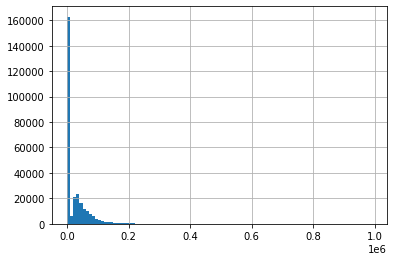

In [5]:
house_df.land_sale_price.hist(bins=np.arange(0,1e6,1e4))

In [6]:
house_df.land_sale_price.value_counts()

0.0         162337
30000.0       2110
45000.0       1942
40000.0       1860
35000.0       1770
             ...  
206000.0         1
228700.0         1
168100.0         1
253000.0         1
108920.0         1
Name: land_sale_price, Length: 3779, dtype: int64

<AxesSubplot:>

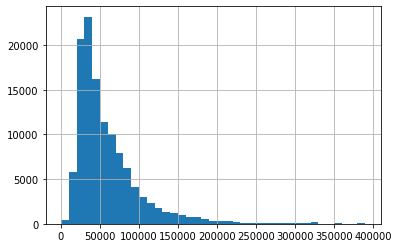

In [7]:
lsp = house_df.land_sale_price
lsp = lsp[lsp != 0]
lsp.hist(bins=np.arange(0,4e5,1e4))

roughly lognormal distributed

<AxesSubplot:>

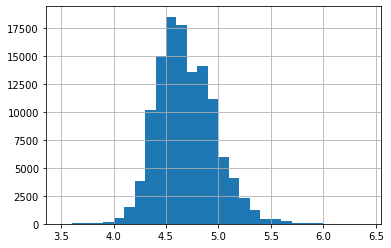

In [8]:
np.log10(lsp).hist(bins=np.arange(3.5,6.5,0.1))

In [9]:
np.round(lsp.describe())

count     121690.0
mean       61577.0
std        67829.0
min          190.0
25%        31000.0
50%        45200.0
75%        73500.0
max      5538500.0
Name: land_sale_price, dtype: float64

### total_sale_price

this is what we are going to predict

<AxesSubplot:>

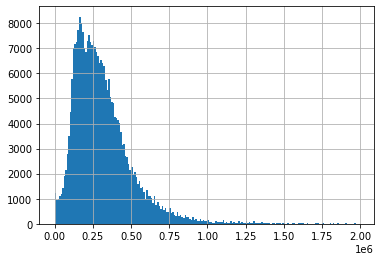

In [10]:
house_df.total_sale_price.hist(bins=np.arange(0,2e6,1e4))

In [11]:
house_df.total_sale_price.value_counts().sort_index()

5.0             1
250.0           4
313.0          15
315.0           1
500.0         145
             ... 
24306400.0     17
25783000.0      3
47925000.0      1
70600000.0      4
91000000.0      2
Name: total_sale_price, Length: 4010, dtype: int64

In [12]:
tsp = house_df.total_sale_price
print(np.percentile(tsp, range(0,10)))
print(np.percentile(tsp, range(90,101)))

[5.00e+00 2.60e+04 5.00e+04 6.80e+04 8.05e+04 9.00e+04 9.90e+04 1.05e+05
 1.11e+05 1.16e+05]
[  551500.   572864.   595000.   620000.   648000.   679500.   724000.
   777000.   860000.  1050370. 91000000.]


In [13]:
print(np.percentile(tsp, np.arange(0,3.1,0.2)))
print(np.percentile(tsp, np.arange(99,100.1,0.1)))

[5.00e+00 3.00e+03 8.00e+03 1.50e+04 2.00e+04 2.60e+04 3.10e+04 3.65e+04
 4.15e+04 4.60e+04 5.00e+04 5.50e+04 5.90e+04 6.20e+04 6.50e+04 6.80e+04]
[ 1050370.          1097766.          1140000.          1190000.
  1250000.          1300000.          1380000.          1502960.99999992
  1706421.99999979  2071934.99999968 91000000.        ]


<AxesSubplot:>

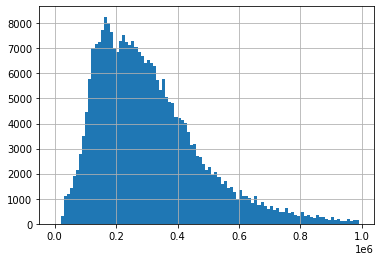

In [14]:
l, r = np.percentile(tsp, [1, 99.5])
tsp = tsp[(tsp > l) & (tsp < r)]
tsp.hist(bins=np.arange(0,1e6,1e4))

In [15]:
# clean 1.5% outliers
house_df = house_df[(house_df["total_sale_price"] > l) &
                    (house_df["total_sale_price"] < r)]
# create log house px
house_df["log_px"] = np.log10(house_df["total_sale_price"])

somewhere between normal and lognormal

<AxesSubplot:>

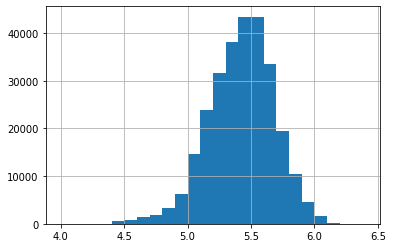

In [16]:
np.log10(tsp).hist(bins=np.arange(4,6.5,0.1))

In [17]:
# note this is after dropping 2% outliers
np.round(tsp.describe())

count     279674.0
mean      312151.0
std       181955.0
min        26500.0
25%       179500.0
50%       275000.0
75%       399000.0
max      1299000.0
Name: total_sale_price, dtype: float64

<AxesSubplot:xlabel='year'>

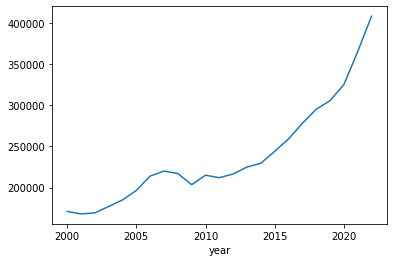

In [18]:
# see trend
house_df.groupby("year")["total_sale_price"].median().plot()

In [52]:
house_df.columns

Index(['land_sale_price', 'total_sale_price', 'deed_date',
       'assessed_building_value', 'story_height', 'heated_area', 'utilities',
       'bath', 'type_and_use', 'physical_zip_code', 'physical_city',
       'mort_rate', 'unemploy_rate', 'pop_growth_rate', 'covid_cases',
       'is_covid', 'lumber_price', 'metals_price', 'build_price', 'int_rate',
       'manufactured_house_number', 'hai', 'wake_supply_index',
       'wake_demand_index', 'year', 'log_px', 'bath_unknown'],
      dtype='object')

<AxesSubplot:xlabel='year'>

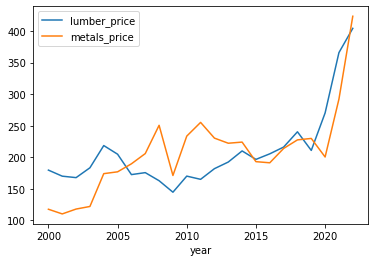

In [59]:
house_df[["lumber_price","metals_price","year"]].drop_duplicates(["year"]).set_index("year").sort_index().plot()

<AxesSubplot:xlabel='year'>

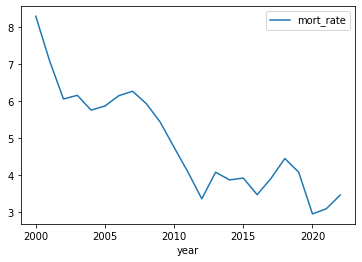

In [60]:
house_df[["mort_rate","year"]].drop_duplicates(["year"]).set_index("year").sort_index().plot()

<AxesSubplot:xlabel='year'>

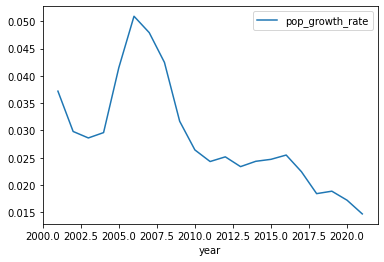

In [63]:
house_df[["pop_growth_rate","year"]].drop_duplicates(["year"]).set_index("year").sort_index().plot()

### deed_date

<AxesSubplot:>

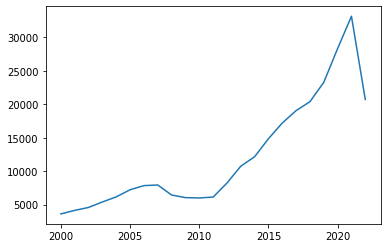

In [19]:
# seeing some trend changes
house_df["year"].value_counts().sort_index().plot()

### assessed_building_value

<AxesSubplot:>

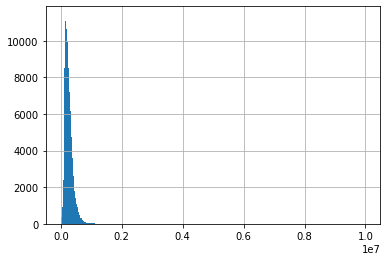

In [20]:
house_df.assessed_building_value.hist(bins=np.arange(0,1e7,1e4))

In [21]:
np.round(house_df.assessed_building_value.describe())

count      279674.0
mean       259558.0
std        148629.0
min             0.0
25%        164443.0
50%        231192.0
75%        322098.0
max      18296504.0
Name: assessed_building_value, dtype: float64

### story_height

In [22]:
house_df.story_height.value_counts()

2.00    133290
1.00     81175
1.50     20237
1.75     18690
1.88     12516
1.63      6924
1.40      4347
3.00      1260
2.50         6
2.40         3
2.63         1
2.75         1
Name: story_height, dtype: int64

The numeric value for story height does not have linear relationship with price

Non-integer story heights of 1.4, 1.5, 1.63, etc. may correspond to multiple levels, hence better price than 2 story.
We need to investigate more the usefulness of this feature.

<AxesSubplot:xlabel='story_height'>

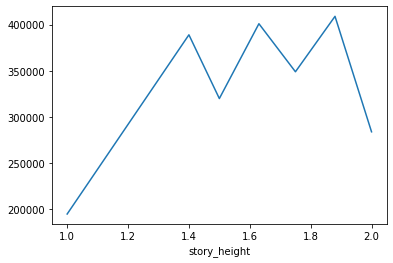

In [72]:
house_df[(house_df["story_height"] <= 2)].groupby("story_height")["total_sale_price"].median().sort_index().plot()

<AxesSubplot:>

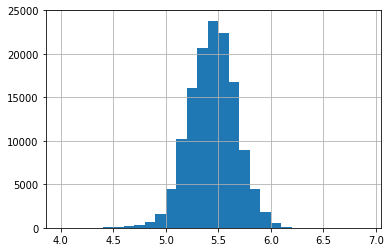

In [24]:
np.log10(house_df[(house_df["story_height"] == 2)]["total_sale_price"]).hist(bins=np.arange(4,7,0.1))

<AxesSubplot:>

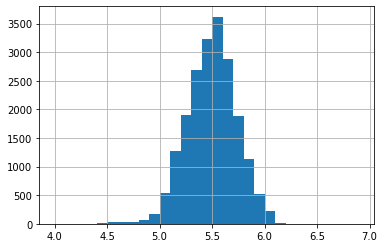

In [25]:
np.log10(house_df[(house_df["story_height"] == 1.5)]["total_sale_price"]).hist(bins=np.arange(4,7,0.1))

<AxesSubplot:>

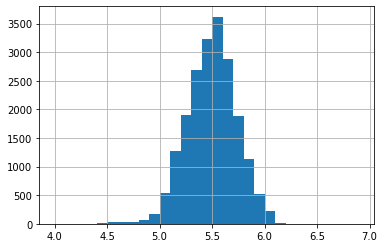

In [26]:
np.log10(house_df[(house_df["story_height"] == 1.5)]["total_sale_price"]).hist(bins=np.arange(4,7,0.1))

story_height
1.50    AxesSubplot(0.125,0.125;0.775x0.755)
1.75    AxesSubplot(0.125,0.125;0.775x0.755)
1.88    AxesSubplot(0.125,0.125;0.775x0.755)
Name: total_sale_price, dtype: object

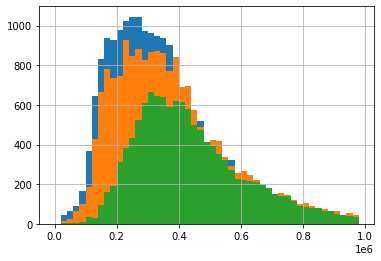

In [27]:
house_df[(house_df["story_height"].isin([1.5,1.75,1.88]))].groupby("story_height")\
    ["total_sale_price"].hist(bins=np.arange(0,1e6,2e4))

story_height
1.4    AxesSubplot(0.125,0.125;0.775x0.755)
Name: total_sale_price, dtype: object

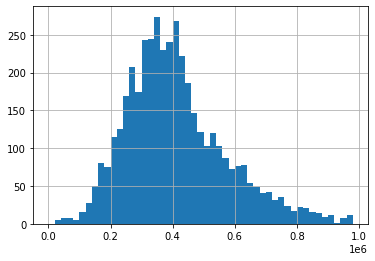

In [28]:
house_df[(house_df["story_height"].isin([1.4]))].groupby("story_height")\
    ["total_sale_price"].hist(bins=np.arange(0,1e6,2e4))

<AxesSubplot:xlabel='story_height'>

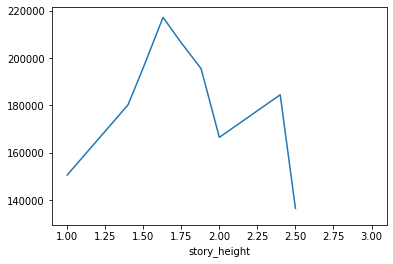

In [29]:
house_df[(house_df["story_height"] <= 3)].groupby("story_height")["total_sale_price"].std().sort_index().plot()

<AxesSubplot:xlabel='story_height'>

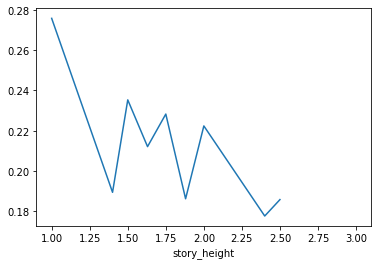

In [51]:
house_df[(house_df["story_height"] <= 3)].groupby("story_height")["log_px"].std().sort_index().plot()

### bath

In [30]:
# create two features "bath_unknown" for bath==0, and "bath" for bath >= 0
# "bath_unknown" includes "adequate, no plumbing, limited plumbing, no of fixtures"
print(house_df.bath.value_counts().sort_index())
house_df["bath_unknown"] = 0
house_df.loc[(house_df["bath"] == 0), "bath_unknown"] = 1

0.0     10269
1.0      9127
1.5      8043
2.0     48189
2.5    118981
3.0     28336
3.5     55491
Name: bath, dtype: int64


<AxesSubplot:xlabel='bath'>

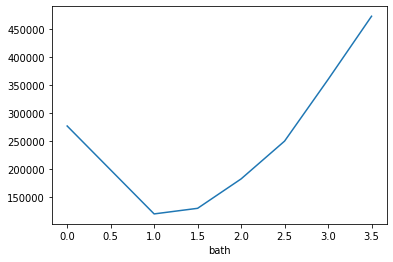

In [31]:
# from the avg price we see "bath_unknown"s' median is somewhere between 1 - 3.5 baths
# so it should not be treated as 0 baths.
house_df.groupby("bath")["total_sale_price"].median().plot()

<AxesSubplot:xlabel='bath'>

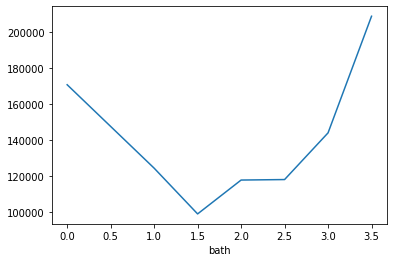

In [32]:
house_df.groupby("bath")["total_sale_price"].std().plot()

<AxesSubplot:xlabel='bath'>

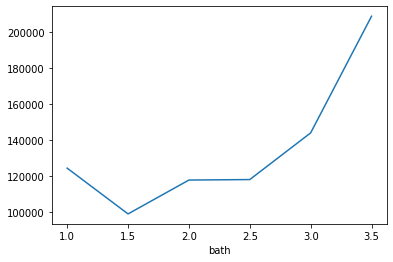

In [33]:
house_df[(house_df["bath"] >= 1)].groupby("bath")["total_sale_price"].std().plot()

<AxesSubplot:xlabel='bath'>

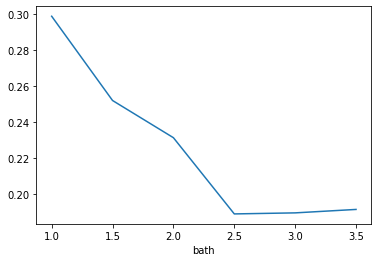

In [34]:
house_df[(house_df["bath"] >= 1)].groupby("bath")["log_px"].std().plot()

<AxesSubplot:>

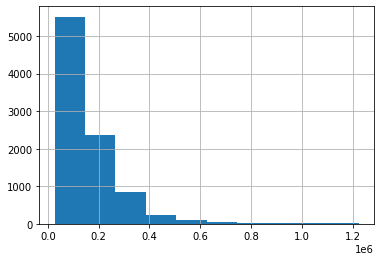

In [39]:
house_df[(house_df["bath"]==1)]["total_sale_price"].hist(bins=np.arange())

### type_use

In [38]:
print(house_df["type_and_use"].value_counts())
house_df = house_df[(house_df["type_and_use"] == 1)]

1.0    279643
Name: type_and_use, dtype: int64


### physical_zip_code

In [42]:
print(house_df["physical_zip_code"].value_counts())
house_df = house_df[(house_df["physical_zip_code"] != 0)]

27587    20068
27519    16889
27610    16241
27526    15351
27616    14852
27502    14239
27540    13611
27603    12088
27615    11584
27613    11067
27513    10908
27604    10629
27614     9437
27612     8929
27529     8537
27545     8022
27511     7779
27606     7465
27609     7234
27560     7186
27539     6909
27591     5176
27518     5080
27523     4581
27617     4576
27597     3972
27607     3725
27608     3171
27571     2702
27592     2368
27601     1691
27605     1388
27562     1184
27501      339
27520      235
27703      144
27596      124
27522       53
27713        1
Name: physical_zip_code, dtype: int64


In [48]:
# use 27587 as base case
house_df.groupby("physical_zip_code")["log_px"].describe().sort_values("std")

,count,mean,std,min,25%,50%,75%,max
physical_zip_code,,,,,,,,
27703,144.0,5.445853,0.091207,5.093422,5.387167,5.436951,5.495024,5.732394
27501,339.0,5.445203,0.126783,4.716003,5.391816,5.447158,5.509874,5.767156
27571,2702.0,5.490098,0.172520,4.537819,5.390935,5.505150,5.603144,6.068260
27519,16889.0,5.586230,0.184281,4.447158,5.469822,5.588832,5.716003,6.110590
27560,7186.0,5.451725,0.186176,4.477121,5.322219,5.471292,5.572872,6.105510
27616,14852.0,5.305152,0.189021,4.431364,5.174277,5.311754,5.439333,6.041393
27523,4581.0,5.632590,0.198591,4.439333,5.505150,5.643453,5.769746,6.113442
27520,235.0,5.242791,0.198776,4.423246,5.113943,5.230449,5.397940,5.724276
27562,1184.0,5.636989,0.202372,4.431364,5.582063,5.642465,5.716838,6.107549


In [40]:
print(house_df["physical_city"].value_counts())

RALEIGH          124078
CARY              40659
APEX              25733
WAKE FOREST       20071
FUQUAY VARINA     15351
HOLLY SPRINGS     13611
GARNER             8537
KNIGHTDALE         8022
MORRISVILLE        7186
WENDELL            5186
ZEBULON            3989
ROLESVILLE         2702
WILLOW SPRING      2369
NEW HILL           1188
ANGIER              339
CLAYTON             235
DURHAM              145
YOUNGSVILLE         124
CREEDMOOR            53
Name: physical_city, dtype: int64


## Regression

In [65]:
house_df.columns

Index(['land_sale_price', 'total_sale_price', 'deed_date',
       'assessed_building_value', 'story_height', 'heated_area', 'utilities',
       'bath', 'type_and_use', 'physical_zip_code', 'physical_city',
       'mort_rate', 'unemploy_rate', 'pop_growth_rate', 'covid_cases',
       'is_covid', 'lumber_price', 'metals_price', 'build_price', 'int_rate',
       'manufactured_house_number', 'hai', 'wake_supply_index',
       'wake_demand_index', 'year', 'log_px', 'bath_unknown'],
      dtype='object')

In [82]:
import statsmodels.api as sm
yvar = "log_px"

intercept = ["I"]
macro = ["mort_rate", "lumber_price"]

xvars = intercept + macro
reg_df = house_df.copy()
reg_df["I"] = 1
reg_df = reg_df[(reg_df[[yvar]+xvars].notnull().all(axis=1))]

model = sm.OLS(reg_df[yvar], reg_df[xvars]).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 log_px   R-squared:                       0.091
Model:                            OLS   Adj. R-squared:                  0.091
Method:                 Least Squares   F-statistic:                 2.763e+04
Date:                Fri, 30 Sep 2022   Prob (F-statistic):               0.00
Time:                        23:08:33   Log-Likelihood:                -4558.2
No. Observations:              276455   AIC:                             9120.
Df Residuals:                  276453   BIC:                             9141.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
I                5.1669      0.002   3231.555   

In [69]:
10**5.34

218776.16239495517

In [70]:
import statsmodels.api as sm
yvar = "log_px"

reg_df = house_df.copy()

intercept = ["I"]
macro = ["mort_rate", "lumber_price"]
#### story
# base case is story==2, each of below variable represents difference to story==2
story = ["I_story1", "I_story1-2", "I_story_other"]

reg_df["I_story1"] = 0
reg_df.loc[(reg_df["story_height"] == 1), "I_story1"] = 1

reg_df["I_story1-2"] = 0
reg_df.loc[(reg_df["story_height"] > 1) &
           (reg_df["story_height"] < 2), "I_story1-2"] = 1

reg_df["I_story_other"] = 0
reg_df.loc[(reg_df["story_height"] > 2), "I_story_other"] = 1

#### regression
xvars = intercept + macro + story 

reg_df["I"] = 1
reg_df = reg_df[(reg_df[[yvar]+xvars].notnull().all(axis=1))]

model = sm.OLS(reg_df[yvar], reg_df[xvars]).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 log_px   R-squared:                       0.240
Model:                            OLS   Adj. R-squared:                  0.240
Method:                 Least Squares   F-statistic:                 1.748e+04
Date:                Fri, 30 Sep 2022   Prob (F-statistic):               0.00
Time:                        23:03:18   Log-Likelihood:                 20253.
No. Observations:              276455   AIC:                        -4.049e+04
Df Residuals:                  276449   BIC:                        -4.043e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
I                 5.3468      0.003   1875.107

In [110]:
import statsmodels.api as sm
yvar = "log_px"

reg_df = house_df.copy()

intercept = ["I"]
macro = ["mort_rate", "lumber_price"]
#### story
# base case is story==2, each of below variable represents difference to story==2
story = ["I_story1", "I_story1-2", "I_story_other"]

reg_df["I_story1"] = 0
reg_df.loc[(reg_df["story_height"] == 1), "I_story1"] = 1

reg_df["I_story1-2"] = 0
reg_df.loc[(reg_df["story_height"] > 1) &
           (reg_df["story_height"] < 2), "I_story1-2"] = 1

reg_df["I_story_other"] = 0
reg_df.loc[(reg_df["story_height"] > 2), "I_story_other"] = 1

#### bath
bath = ["I_bath_unknown", "bath"]
reg_df["I_bath_unknown"] = 0
reg_df.loc[(reg_df["bath"] == 0), "I_bath_unknown"] = 1

#### zip
all_zips = reg_df["physical_zip_code"].unique().tolist()
all_zips = [z for z in all_zips if z != 27587]
zip_vars = []
for z in all_zips:
    zip_var = f"I_zip{z}"
    zip_vars.append(zip_var)
    reg_df[zip_var] = 0
    reg_df.loc[(reg_df["physical_zip_code"] == z), zip_var] = 1
    
#### interaction with covid
zip_covid = []
for z in zip_vars:
    col = z + "_covid"
    zip_covid.append(col)
    reg_df[col] = reg_df[z] * reg_df["is_covid"]


#### regression
xvars = intercept + macro + story + bath + ["is_covid"] + zip_vars + zip_covid 

reg_df["I"] = 1
reg_df = reg_df[(reg_df[[yvar]+xvars].notnull().all(axis=1))]

model = sm.OLS(reg_df[yvar], reg_df[xvars]).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 log_px   R-squared:                       0.529
Model:                            OLS   Adj. R-squared:                  0.529
Method:                 Least Squares   F-statistic:                     3725.
Date:                Sat, 01 Oct 2022   Prob (F-statistic):               0.00
Time:                        08:12:10   Log-Likelihood:                 86304.
No. Observations:              275319   AIC:                        -1.724e+05
Df Residuals:                  275235   BIC:                        -1.716e+05
Df Model:                          83                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
I                    4.8080      0.003  

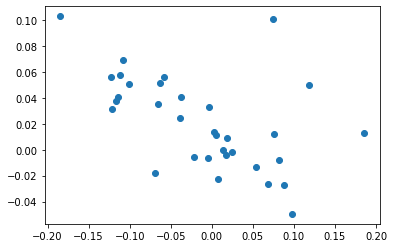

In [107]:
res = model.params[zip_vars].reset_index() # price by zip
res["zip_covid"] = model.params[zip_covid].values # price chg after covide by zip
res["zip"] = all_zips
res = res.drop("index", axis=1)

counts = reg_df.groupby("physical_zip_code").apply(len).reset_index()
counts.columns = ["zip", "cnts"]
res = pd.merge(res, counts, on="zip")
res = res[(res.cnts > 300)]

plt.scatter(res[0], res["zip_covid"])

In [108]:
res

,0,zip_covid,zip,cnts
0,0.185705,0.013083,27608,3131
1,-0.122174,0.055831,27604,10479
2,-0.111861,0.057652,27529,8384
3,-0.058621,0.055814,27511,7680
4,-0.038027,0.040416,27609,7141
5,-0.004013,0.032598,27615,11429
6,0.074790,0.100690,27601,1656
7,0.075281,0.011898,27607,3689
8,-0.184970,0.102998,27610,15913
9,-0.038770,0.024815,27526,14959
